In [1]:
from timeit import Timer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm

#If you're using pybhjet in another directory from where you built it: 
# import sys
# sys.path.append("/path/to/pybhjet")

import sys
sys.path.append("../") 

import build.pybhjet as pybhjet 
import math
from bhjet_plotting import *
bhjet = pybhjet.PyBHJet()

erg2eV = 6.242e+11 #1erg in eV
Hz2eV = 4.13566553853599e-15 # 1Hz in eV
mjy_conv = 1e26 

In [2]:
bhjet.load_params("../ip.dat") 

#command for setting parameters: 
# bhjet.set_parameter("r_0", 10)

#command for listing parameters: 
bhjet.print_parameters()

BHJet Parameters:
-----------------
Mbh      : 6.6e+08     M_sun
theta    : 66          degrees
dist     : 9080        kpc
redsh    : 0.003633    
jetrat   : 0.00064     Jet Power, L_edd
r_0      : 7.72058     Jet base radius, R_g
z_diss   : 24.971      nT particle injection region, R_g
z_acc    : 24.971      Jet acceleration region, R_g
z_max    : 100000      Maximum Jet Distance, R_g
t_e      : 655.986     Temperature of rel. electrons in nozzle, keV
f_nth    : 0.6         Percentage of particles acc. into nT tail 
f_pl     : 4.67634     Dissipation Parameter
pspec    : 1.5         Slope of nT lepton distribution
f_heat   : 1           Shock Heating
f_beta   : 0.1         Adiabatic Cooling Timescale
f_sc     : 7.01e-09     < 0.1, Max. E of nT particles
p_beta   : 0.02        Plasma Beta [Regulates Pair Content in BHJet for velsw > 1] 
sig_acc  : 0.01        Magnetization at acceleration region
l_disk   : 2.3e-06     Disk Luminosity, L_edd
r_in     : 120         Inner Disk Radius, R_g

In [3]:
#running bhjet with set parameters: 
bhjet.cutoff_type = 2
bhjet.set_parameter("f_sc", 7e-9)

bhjet.run()
output = bhjet.get_output()

#for accessing the output/ making plots of the output: 
comp_exp = preprocess_component_output(output)
exp_numdens = preprocess_numdens_output(output)
exp_zone = preprocess_jet_profile(output)

[jetmain] com_min=3.82659e+06 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=120 com_res=6 en_phot_max=9.90275
[jetmain] com_min=930985 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=126 com_res=6 en_phot_max=9.90275
[jetmain] com_min=40579.5 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=132 com_res=6 en_phot_max=9.90275
[jetmain] com_min=27689.7 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=132 com_res=6 en_phot_max=9.90275
[jetmain] com_min=20773.6 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=132 com_res=6 en_phot_max=9.90275
[jetmain] com_min=16446.6 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=132 com_res=6 en_phot_max=9.90275
[jetmain] com_min=13490.7 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=138 com_res=6 en_phot_max=9.90275
[elec Mixed] pmax(last)=0 gamma_max(last)=0
[jetmain] com_min=10443.1 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=138 com_res=6 en_phot_max=9.90275
[elec Mixed] pmax(last)=0 gamma_max(last)=0
[jetmain] com_min=8976 com_max=1.49451e+27 ear_max=6.1808e+09 ncom=138 com_re

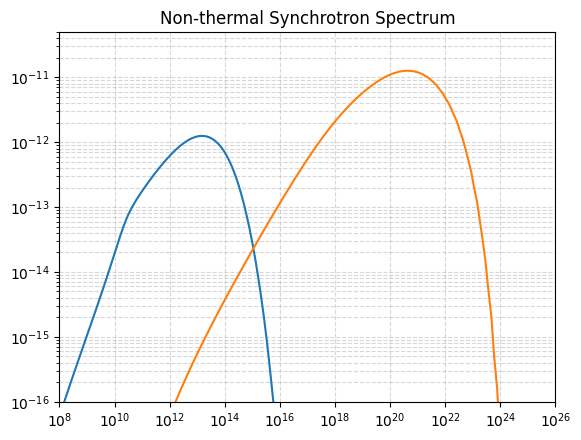

In [4]:
#example of how the data can be directly accesible: 
plt.loglog(comp_exp["postsyn"]["energy"], comp_exp["postsyn"]["flux"]*comp_exp["postsyn"]["energy"]/1e26)
plt.loglog(comp_exp["postcom"]["energy"], comp_exp["postcom"]["flux"]*comp_exp["postcom"]["energy"]/1e26)

plt.title("Non-thermal Synchrotron Spectrum")
plt.ylim(1e-16, 5e-11)
plt.xlim(1e8, 1e26)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
#the data out of bhjet comes as frequency(hz) and flux (mJy)
plt.show()

In [98]:
def plot_numdens(numdens, z_rg, nzones = 100, cmap='magma', skip=10, ytimesp=True, title = None):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    size_arr = len(numdens["momentum"]) // nzones
    norm = Normalize(vmin=np.log10(min(z_rg)), vmax=np.log10(max(z_rg)))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    for j in range(nzones):
        if j % skip != 0:
            continue

        idx_start = j * size_arr
        idx_end = (j + 1) * size_arr
        p = numdens["momentum"][idx_start:idx_end]
        n_p = numdens["n_p"][idx_start:idx_end]
        y = n_p * p if ytimesp else n_p

        color = sm.to_rgba(np.log10(z_rg[j]))
        ax.plot(p, y, color=color, linewidth=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-18, 1e-12)
    ax.set_ylim(5e-9, 1e7)
    ax.set_xlabel("Momentum", fontsize=14)
    ylabel = r"Number density [cm$^{-3}$]" if ytimesp else r"n(p) [cm⁻³ p⁻¹]"
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.3)

    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label(r"$\log_{10}(z / r_g)$", fontsize=14)

    return fig, ax 

(1e-18, 1e-10)

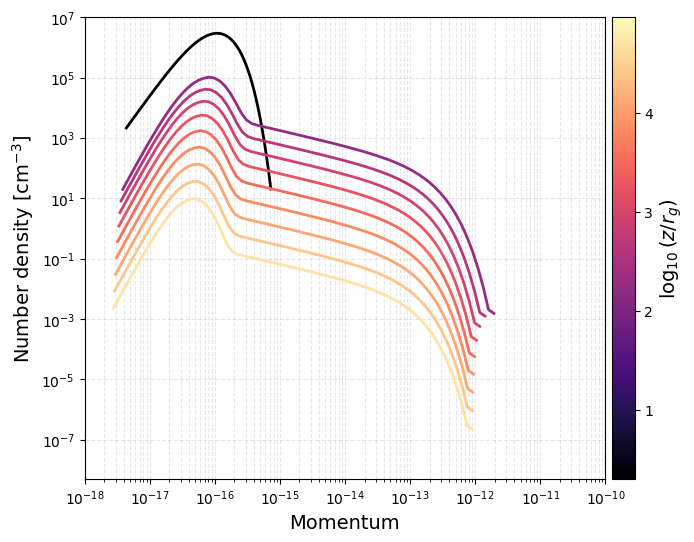

In [99]:
fig, ax = plot_numdens(exp_numdens, exp_zone['z_rg'])

plt.xlim(1e-18, 1e-10)

In [ ]:
def plot_numdens_zone(
    numdens,
    z_rg,
    color, 
    nzones=100,
    zone=None,          # int or None. If int, plot only that zone index.
    cmap="magma",
    skip=1,
    ytimesp=True,
    title=None,
    show_cbar=False      # if plotting one zone, you may want False
):
    size_arr = len(numdens["momentum"]) // nzones

    norm = Normalize(vmin=np.log10(np.min(z_rg)), vmax=np.log10(np.max(z_rg)))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    if zone is not None:
        j_list = [zone]
    else:
        j_list = range(nzones)

    for j in j_list:
        if zone is None and (j % skip != 0):
            continue

        idx_start = j * size_arr
        idx_end = (j + 1) * size_arr

        p = numdens["momentum"][idx_start:idx_end]
        n_p = numdens["n_p"][idx_start:idx_end]
        y = n_p * p if ytimesp else n_p

        #electron spectrum: 
        ax.plot

        ax.plot(p, y, color=color, linewidth=2, alpha = 0.5)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e-18, 1e-12)
    ax.set_ylim(5e-9, 1e7)
    ax.set_xlabel("Momentum", fontsize=14)
    ylabel = r"Number density [cm$^{-3}$]" if ytimesp else r"n(p) [cm$^{-3}$ p$^{-1}$]"
    ax.set_ylabel(ylabel, fontsize=14)

    if title is None and zone is not None:
        ax.set_title(f"Zone {zone} (z_rg={z_rg[zone]:.3g})")
    else:
        ax.set_title(title)

    ax.grid(True, which="both", linestyle="--", alpha=0.3)

    if show_cbar and (zone is None):
        cbar = fig.colorbar(sm, ax=ax, pad=0.01)
        cbar.set_label(r"$\log_{10}(z / r_g)$", fontsize=14)

    plt.tight_layout()